In [1]:
from src import *

In [2]:
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from scipy import stats

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- On static FC
    - [Feature Extraction](feature)
    <!-- - [Data Splitting](data) -->
    - [Inference](#analysis)

- On Gradients
    - [Feature Extraction](feature)
    <!-- - [Data Splitting](data) -->
    - [Inference](#analysis)

In [3]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])
subject_grad = load('./resources/static_grad/individual_level/Rest_grad.pkl')
subjects     = list(subject_grad.keys())

## On Static FC

In [9]:
regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']


In [10]:
mri_path = "./data/fmri400_compiled/"
mri_df   = pd.read_csv(mri_path + "Rest_compiled.csv")

In [11]:
filenames = [mri_df[mri_df.id=='sub-'+s].iloc[0].filename for s in subjects]

In [12]:
subject_timeseries = {subjects[i]: df_to_timeseries(mri_df, filenames[i])[0]  for i in range(len(subjects))}
timeseries = [zscore(subject_timeseries[s].sum(axis=1)) for s in subjects]
timeseries = np.asarray(timeseries)

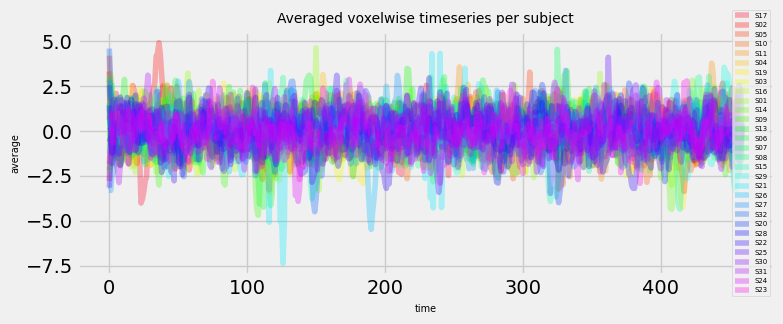

In [281]:
NUM_COLORS = len(subjects)
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for s in subjects:
    tmp = zscore(subject_timeseries[s].sum(axis=1))
    plt.plot(tmp, label=s, alpha=0.3)

ax.set_title('Averaged voxelwise timeseries per subject', size=10)
ax.set_xlabel('time', size=7)
ax.set_ylabel('average', size=7)
ax.legend(loc=7, prop={'size':5})
plt.show()

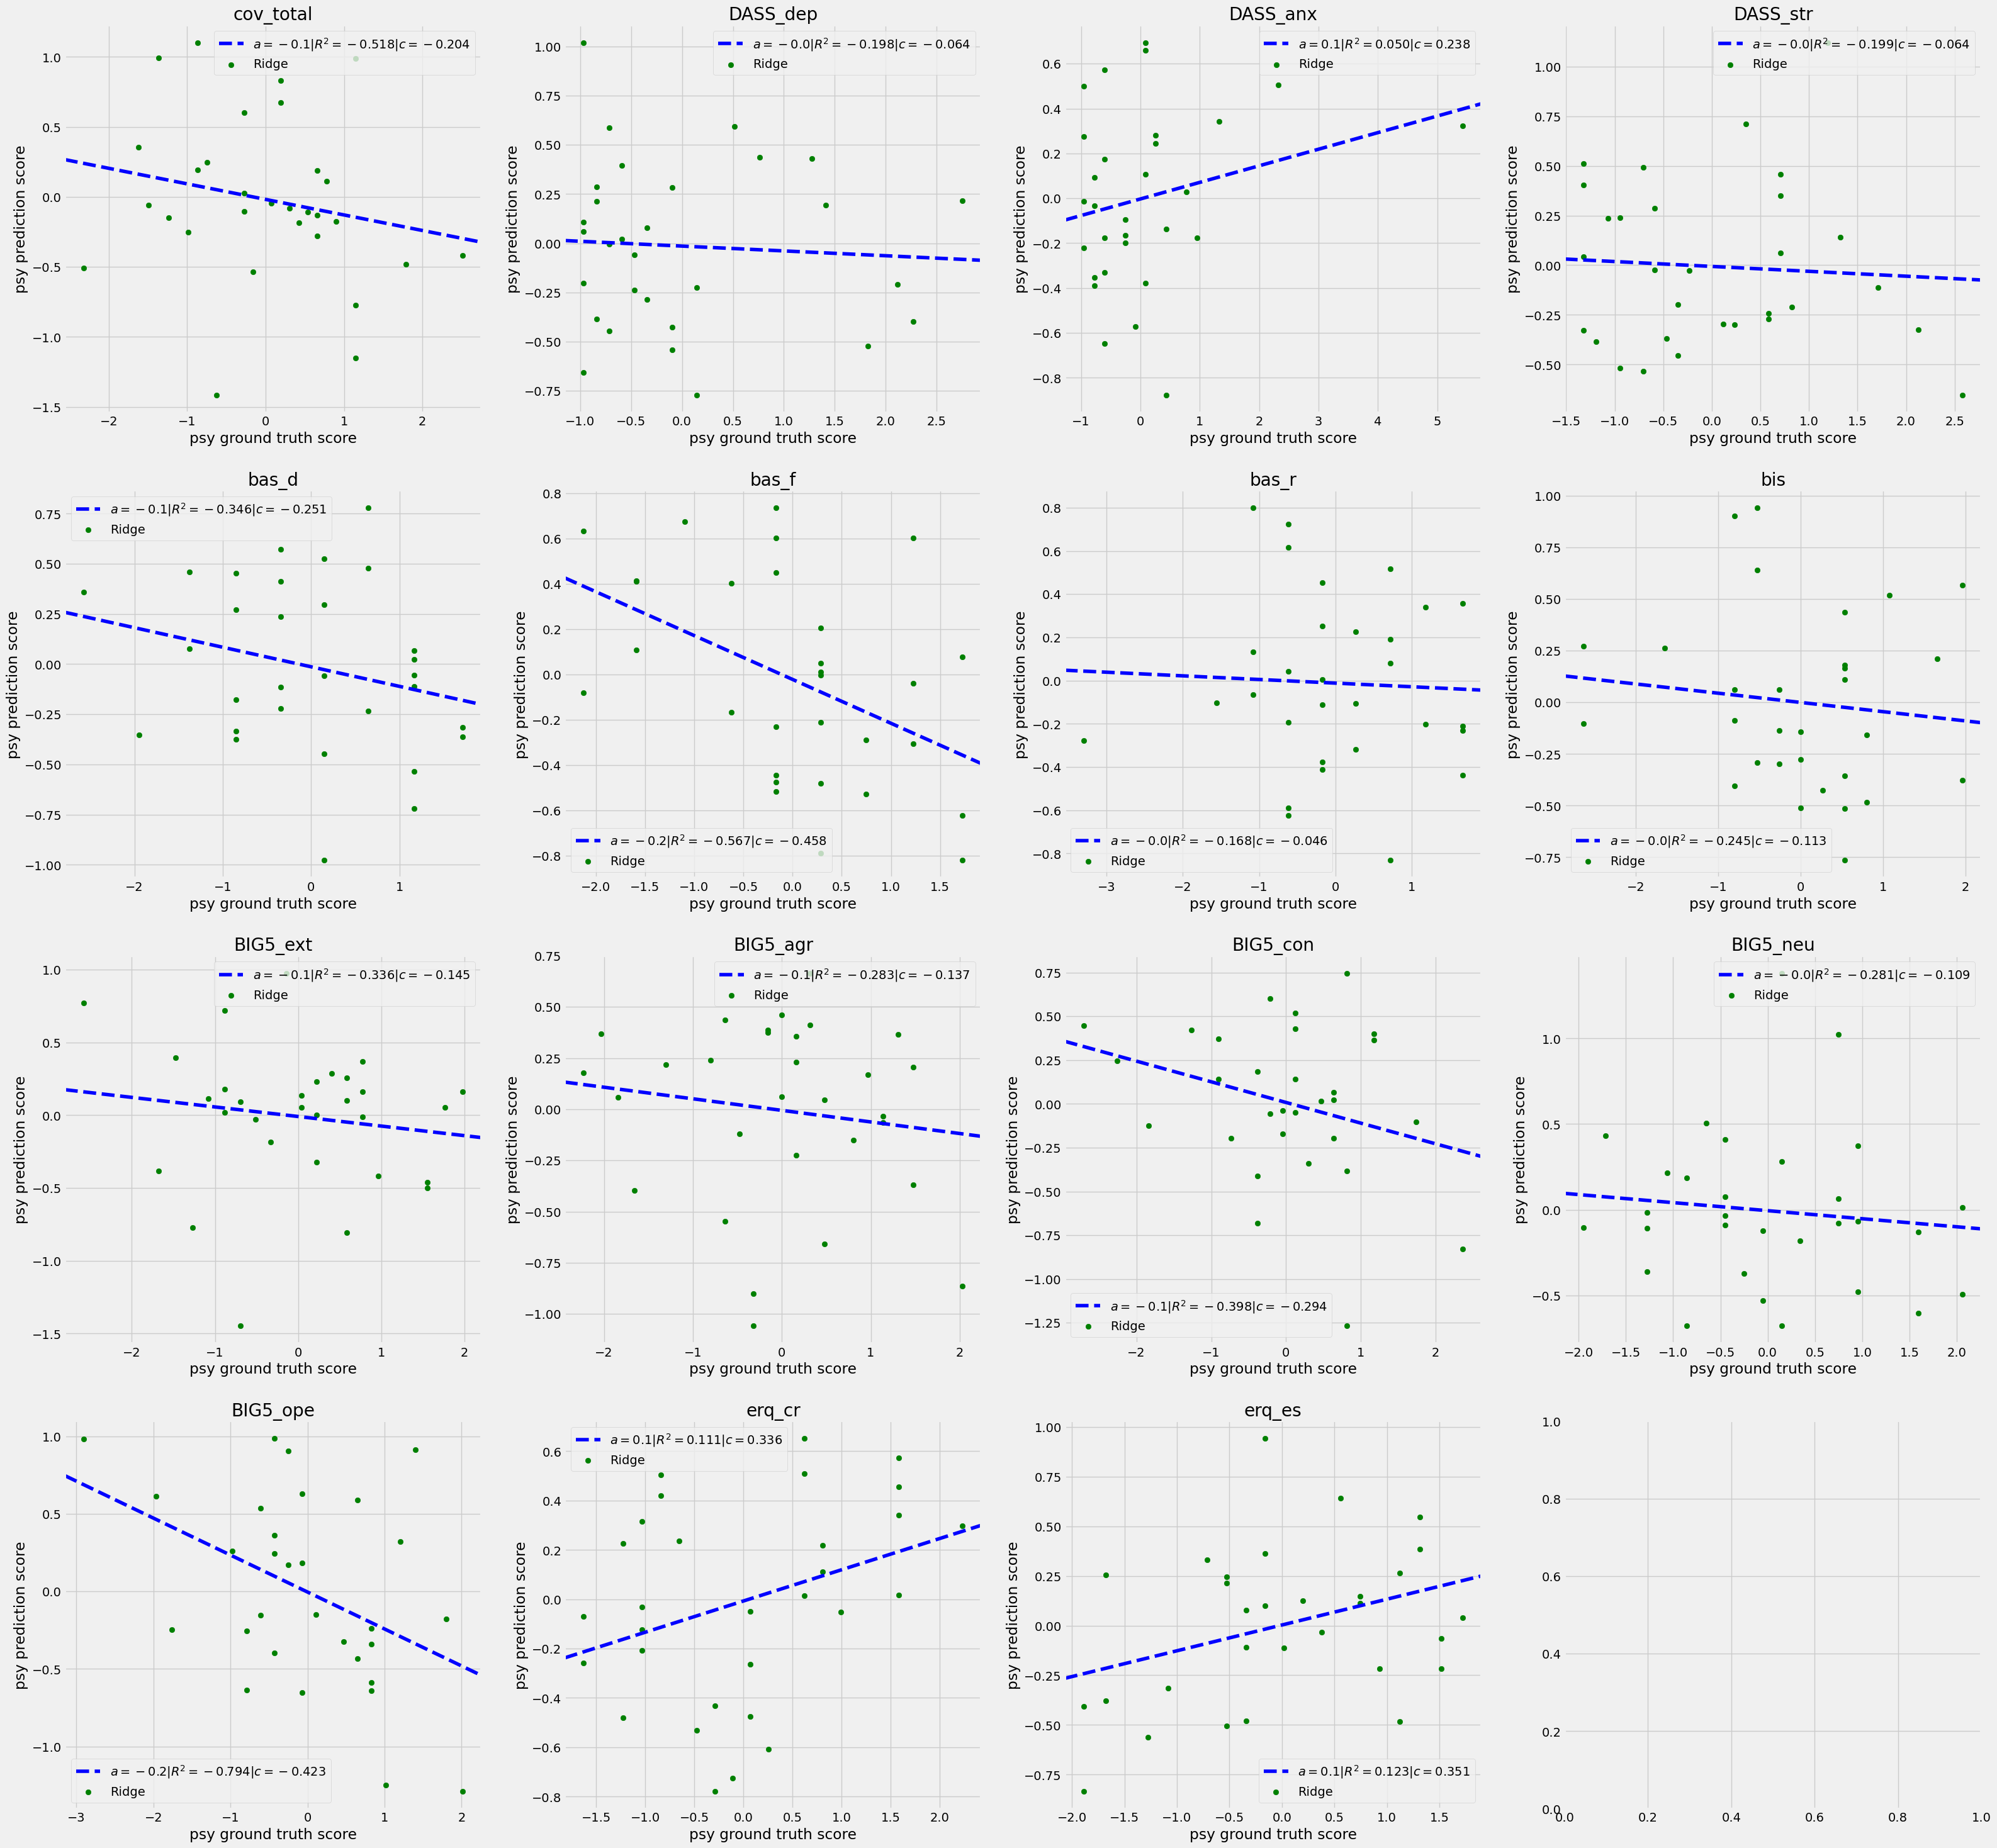

In [287]:
fig, ax = plt.subplots(4,4, figsize=(35,35))
corr_time = np.zeros((len(existing_psy)))
n = len(subjects)
for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(n)]
    psyscore = np.array(psyscore)
    
    pts2 = []
    for j in range(n):

        clf  = Ridge(alpha=10)
        tmp  = np.concatenate([psyscore[:j], psyscore[j+1:]])
        tmp2 = np.concatenate([timeseries[:j], timeseries[j+1:]])

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = timeseries[j]
        gt = (psyscore[j]-m)/s
    
        pts2.append([clf.predict([topredict])[0], gt])

    pts2 = np.asarray(pts2)
    r2   = r2_score(pts2[:,1],pts2[:,0])
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    corr   = stats.pearsonr(pts2[:,0], pts2[:,1]).statistic
    corr_time[i] = corr
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={corr:.3f}$', color='b')

    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

In [288]:
np.random.seed(99)
distribsC = []
n = len(psyscore)
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    
    null_distrib = []
    for _ in range(1000):
        np.random.shuffle(psyscore)
        pts2 = []
        for j in range(n):

            clf  = Ridge(alpha=10)
            tmp  = np.concatenate([psyscore[:j], psyscore[j+1:]])
            tmp2 = np.concatenate([timeseries[:j], timeseries[j+1:]])

            y, m, s = zscore(tmp, ret_param=True)
            clf.fit(tmp2, y)

            topredict = timeseries[j]
            gt = (psyscore[j]-m)/s
        
            pts2.append([clf.predict([topredict])[0], gt])

        pts2 = np.asarray(pts2)
        corr   = stats.pearsonr(pts2[:,0], pts2[:,1]).statistic
        null_distrib.append(corr)
    distribsC.append(null_distrib)

100%|██████████| 15/15 [03:08<00:00, 12.58s/it]


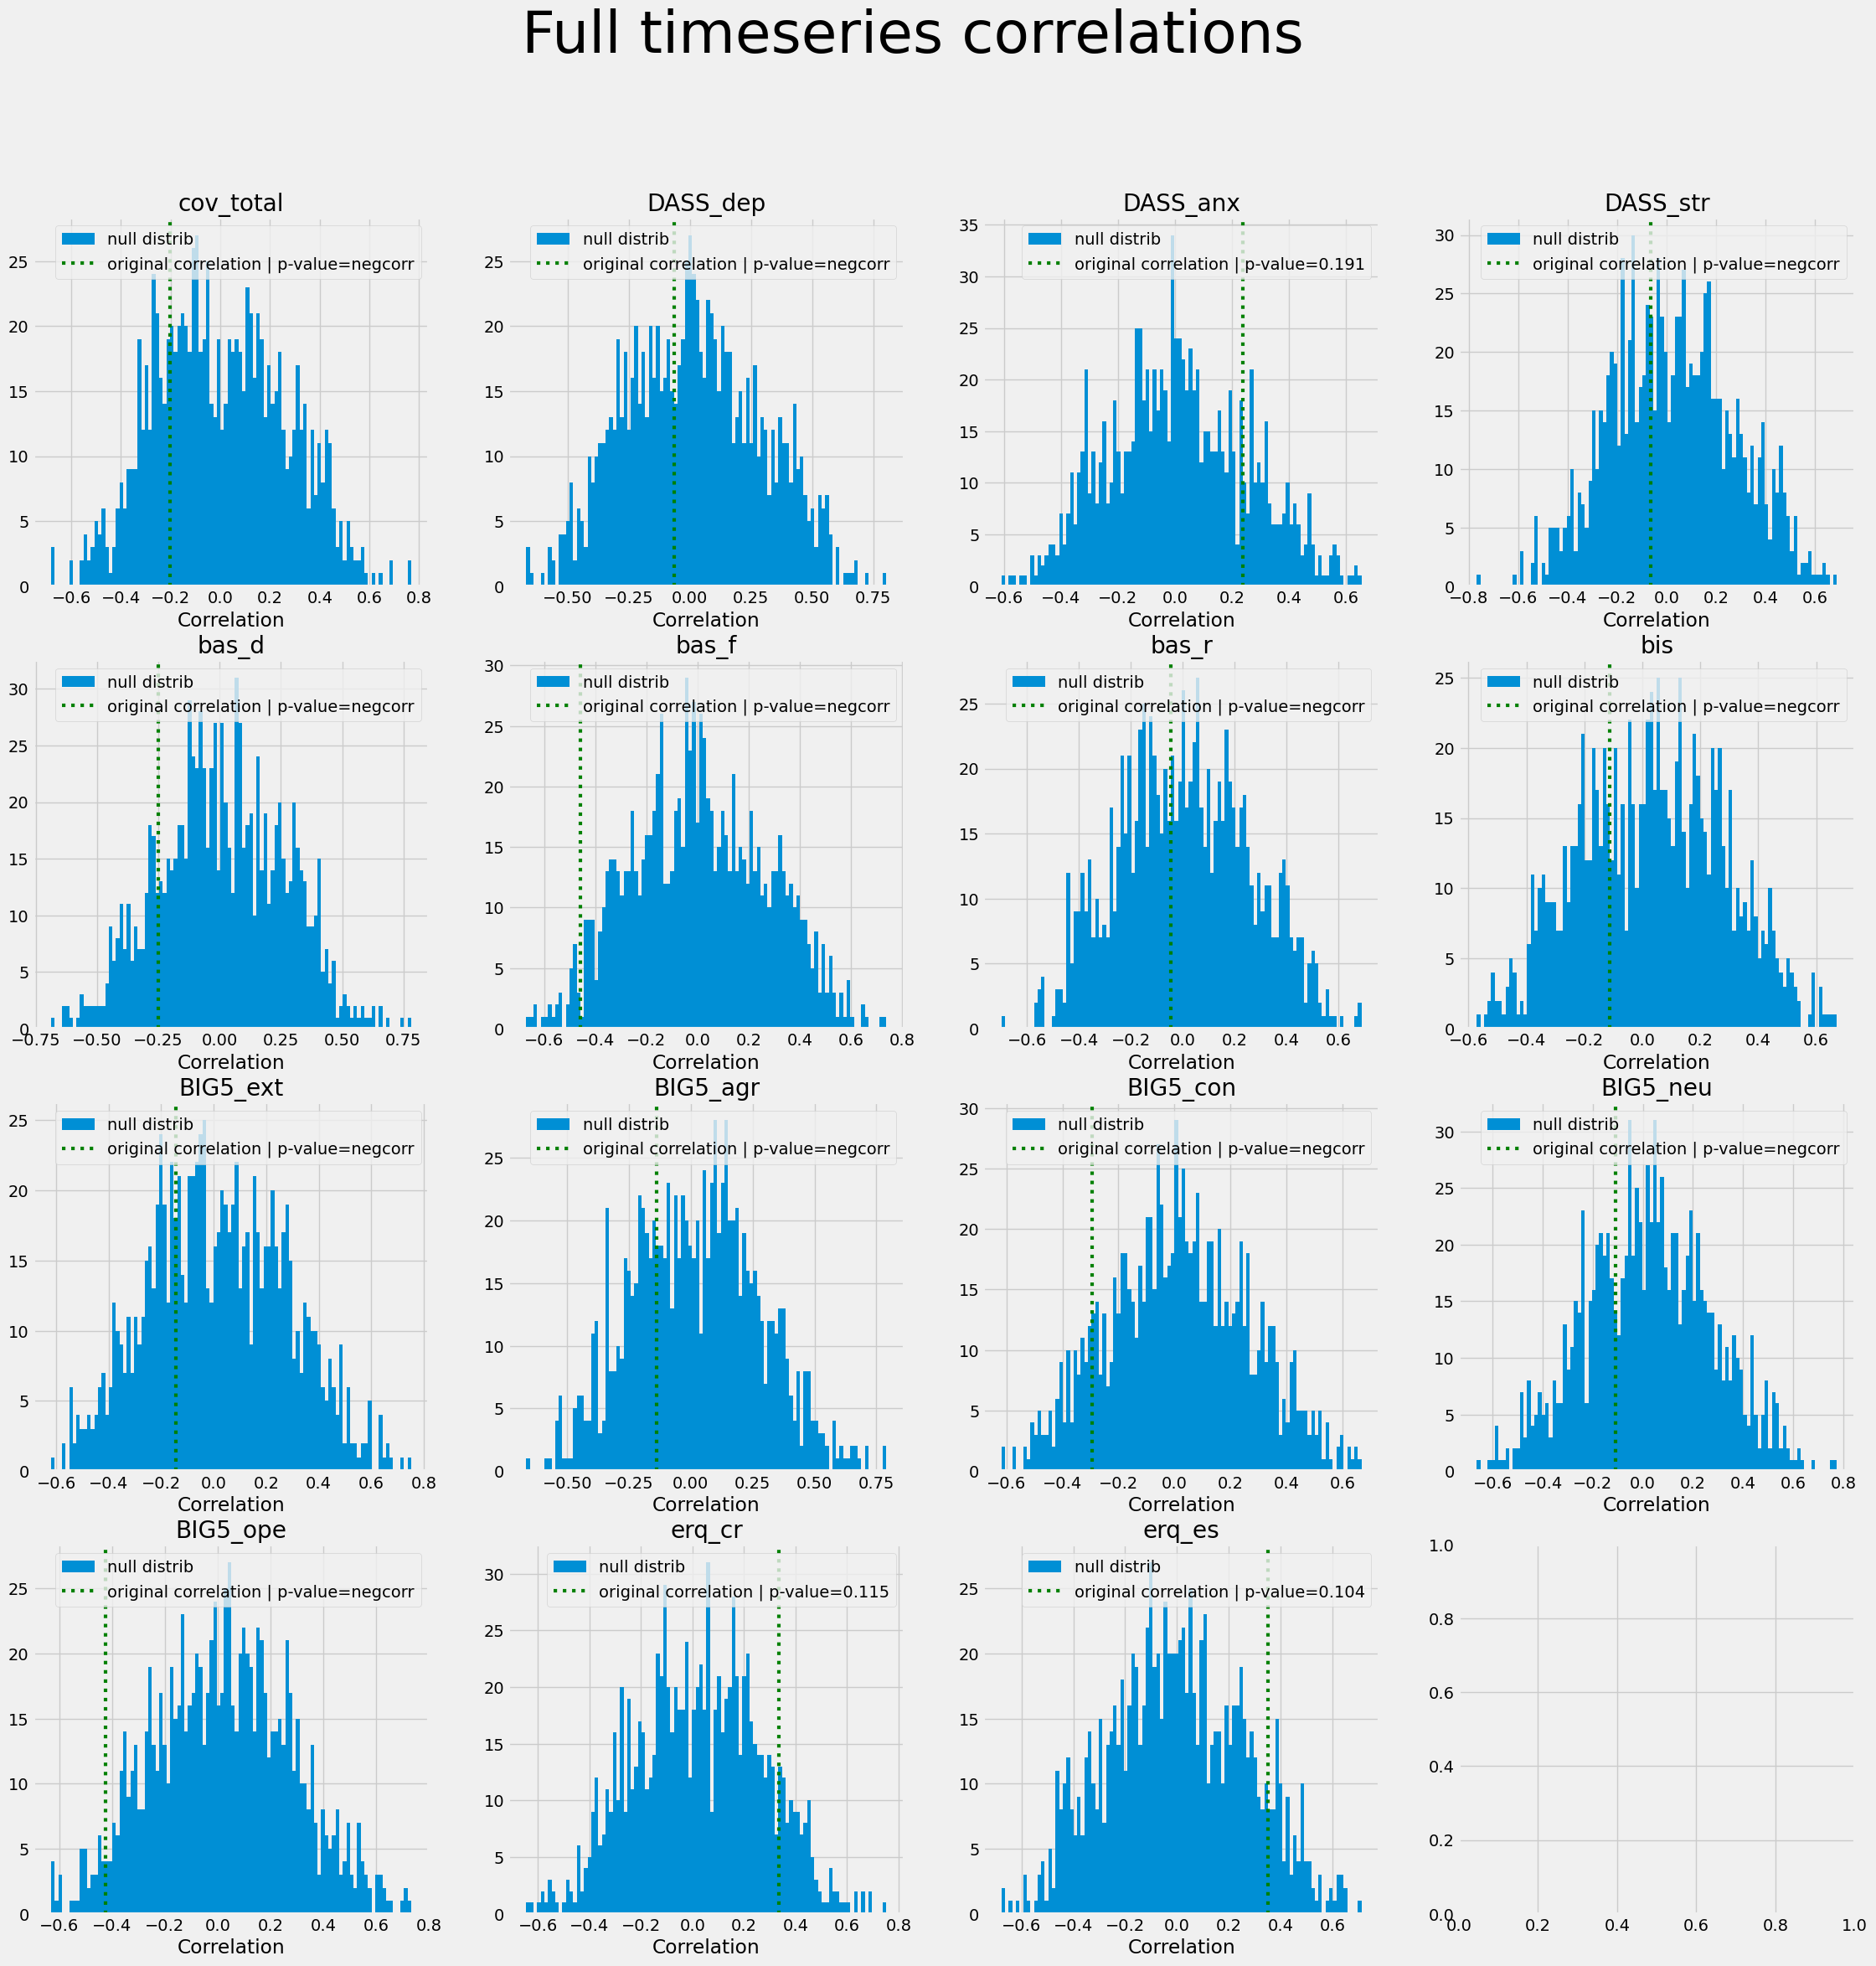

In [289]:
fig, ax = plt.subplots(4,4, figsize=(25,25))

for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    pval = null_score(distribsC[i], corr_time[i])
    ax[r,c].hist(distribsC[i], bins=100, label='null distrib')

    if corr_time[i] >= 0:
        ax[r,c].axvline(x=corr_time[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format(pval))
        nbstar = int(pval < 0.05) + int(pval < 0.1) + int(pval < 0.001)
        ax[r,c].set_title(feat + ' *'*nbstar)
    else:
        ax[r,c].axvline(x=corr_time[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format("negcorr"))
        ax[r,c].set_title(feat)

    ax[r,c].set_xlabel('Correlation')
    ax[r,c].legend()

plt.suptitle('Full timeseries correlations', size=50)
plt.show()

## On Static Gradients

In [4]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad.pkl')
subjects     = list(subject_grad.keys())

#### Feature Extraction

In [5]:
subjects     = list(subject_grad.keys())
regions      = list(index2region.keys())
print(subjects)
print(regions)

['S17', 'S02', 'S05', 'S10', 'S11', 'S04', 'S19', 'S03', 'S16', 'S01', 'S14', 'S09', 'S13', 'S06', 'S07', 'S08', 'S15', 'S29', 'S21', 'S26', 'S27', 'S32', 'S20', 'S28', 'S22', 'S25', 'S30', 'S31', 'S24', 'S23']
['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']


In [6]:
L = [subject_grad[s] for s in subjects]
aligned, _ , score = procrustes_align(L)
print(score)
subject_grad = {subjects[i]: aligned[i] for i in range(len(subjects))}

65.3493982936322


In [7]:
feat     = existing_psy[0]
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
order    = np.argsort(psyscore)
print(feat)

cov_total


In [8]:
# 1. Volume computing 
features = np.zeros((len(subjects), len(regions)))
for sidx in range(len(subjects)):
    for ridx in range(len(regions)):
        features[sidx, ridx] = network_volume(subject_grad[subjects[sidx]], regions[ridx])

gradients = np.asarray([subject_grad[s] for s in subjects])

# 2/3. Full gradients and variances
G1,G2,coloring = [],[],[]
V1,V2,c2       = [],[],[]

for i in order:
    G1 += list(gradients[i][:,0])
    G2 += list(gradients[i][:,1])
    coloring += [psyscore[i]] * 400
    
    V1 += [gradients[i][:,0].std()]
    V2 += [gradients[i][:,2].std()]
    c2 += [psyscore[i]]

#### Visual difference

In [9]:
# NUM_COLORS = len(features)
# cm = plt.get_cmap('gist_rainbow')
# fig = plt.figure(figsize=(8,3))
# ax = fig.add_subplot(111)
# ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

# for i in order:
#     plt.plot(features[i], label='subj{}: {}'.format(i, psyscore[i]), linewidth=2)

# plt.title('Network volumes across subjects', size=10)
# plt.xlabel('Network number', size=7)
# plt.ylabel('Volume', size=7)
# plt.legend(loc=5, prop={'size':4})
# plt.show()

Text(25.09722222222222, 0.5, 'G2')

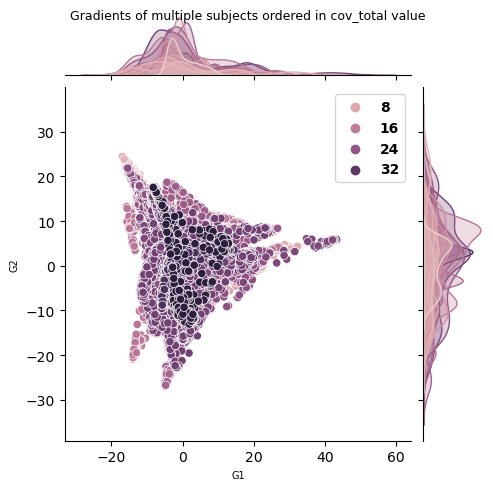

In [10]:
tmp_df = {"G1": G1 , "G2": G2, feat: coloring}

ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue=feat, height=5)
ax.fig.suptitle("Gradients of multiple subjects ordered in {} value".format(feat), size=9)
legend_properties = {'weight':'bold','size':10}
ax.ax_joint.legend(prop=legend_properties,loc='upper right')
ax.ax_joint.set_xlabel('G1', size=7)
ax.ax_joint.set_ylabel('G2', size=7)

### Regress / Predictive

Ridge on Full gradients (3 gradients)

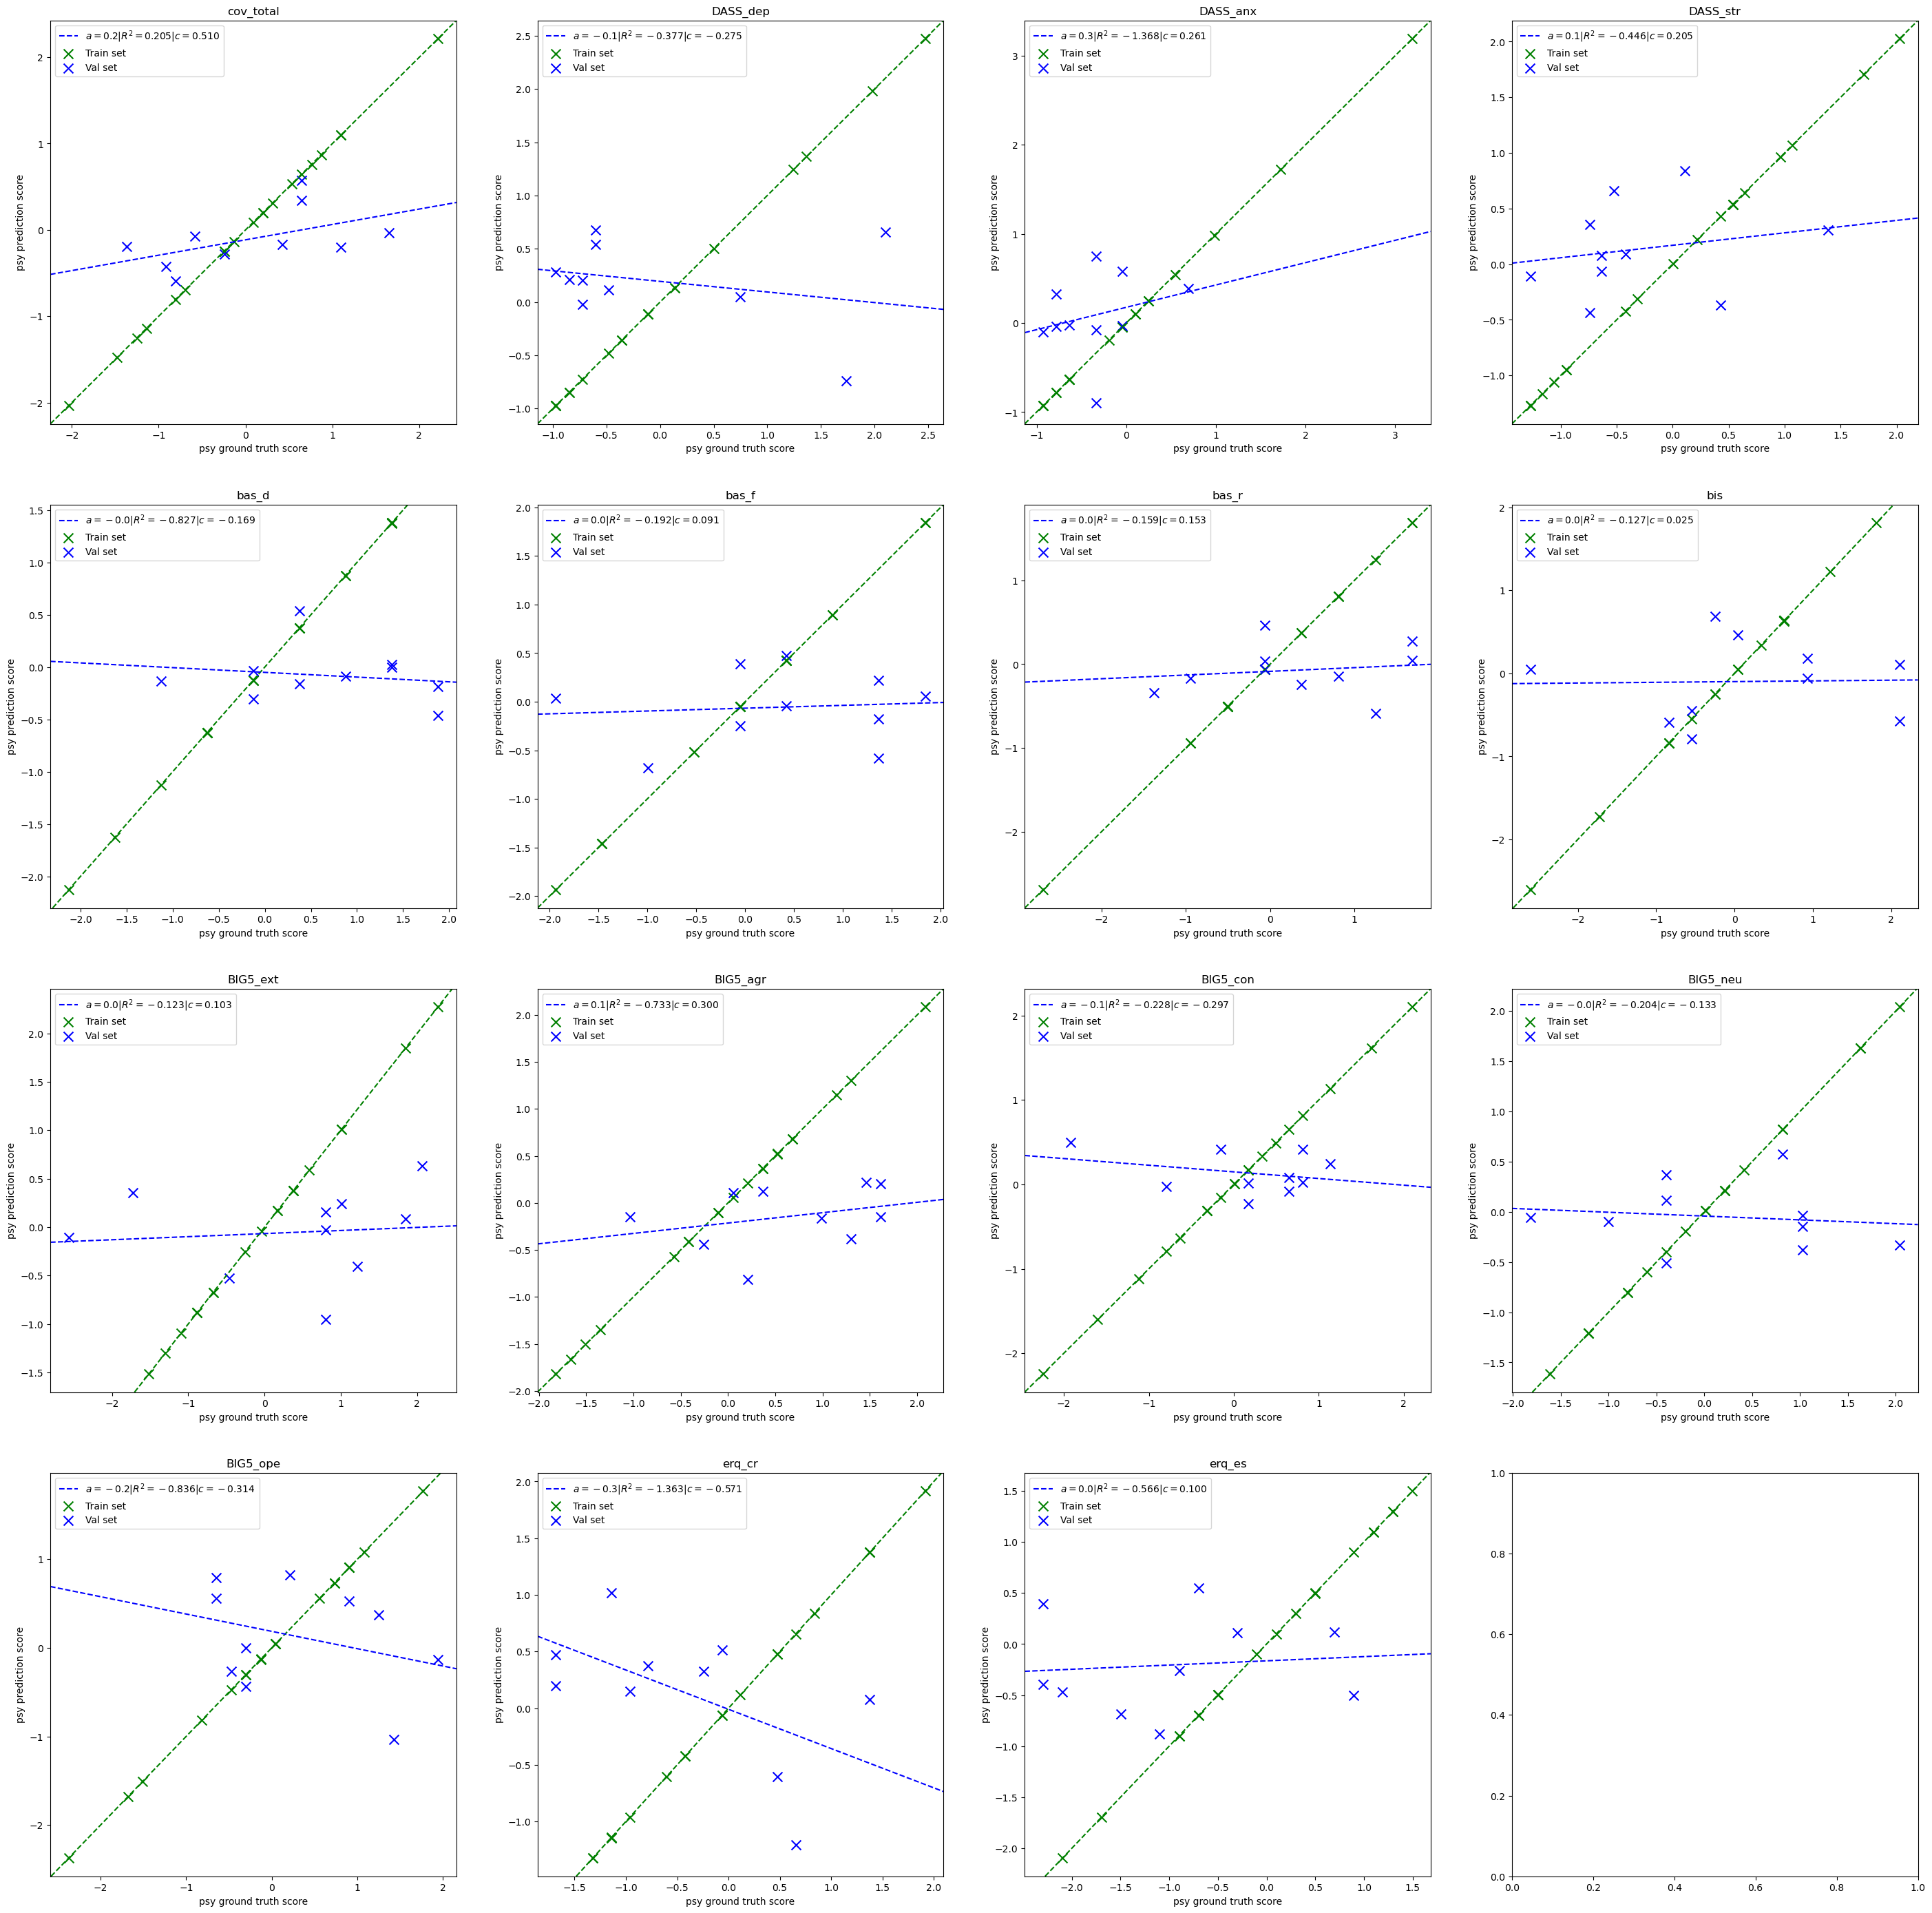

In [11]:
fig, ax = plt.subplots(4,4, figsize=(35,35))
corr_grad = np.zeros((len(existing_psy)))
n = len(psyscore)
for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    
    # leave one out val prediction score
    j = 20
    clf  = Ridge(alpha=5)
    tmp  = psyscore[:j]
    tmp2 = gradients[:j]
    tmp2 = tmp2.reshape(j, -1)

    y, m, s = zscore(tmp, ret_param=True)
    clf.fit(tmp2, y)

    topredict = gradients[j:]
    gt   = (psyscore[j:]-m)/s

    pred1 = clf.predict(tmp2)
    pred2 = clf.predict(topredict.reshape(30-j,-1))
    
    r2   = r2_score(gt,pred2)
    m1, b1 = np.polyfit(y, pred1, deg=1)
    m2, b2 = np.polyfit(gt, pred2, deg=1)
    corr   = stats.pearsonr(gt, pred2).statistic
    corr_grad[i] = corr
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, color='g')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={corr:.3f}$', color='b')

    ax[r,c].scatter(y, pred1, s=100, marker='x', color='g', label="Train set")
    ax[r,c].scatter(gt, pred2, s=100, marker='x', color='b', label="Val set")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

Using all parameters associated to the full gradients shows large sign of overfitting the train set and shows sand large issue of an underdefined problem.

Ridge on Features (volume of each network)

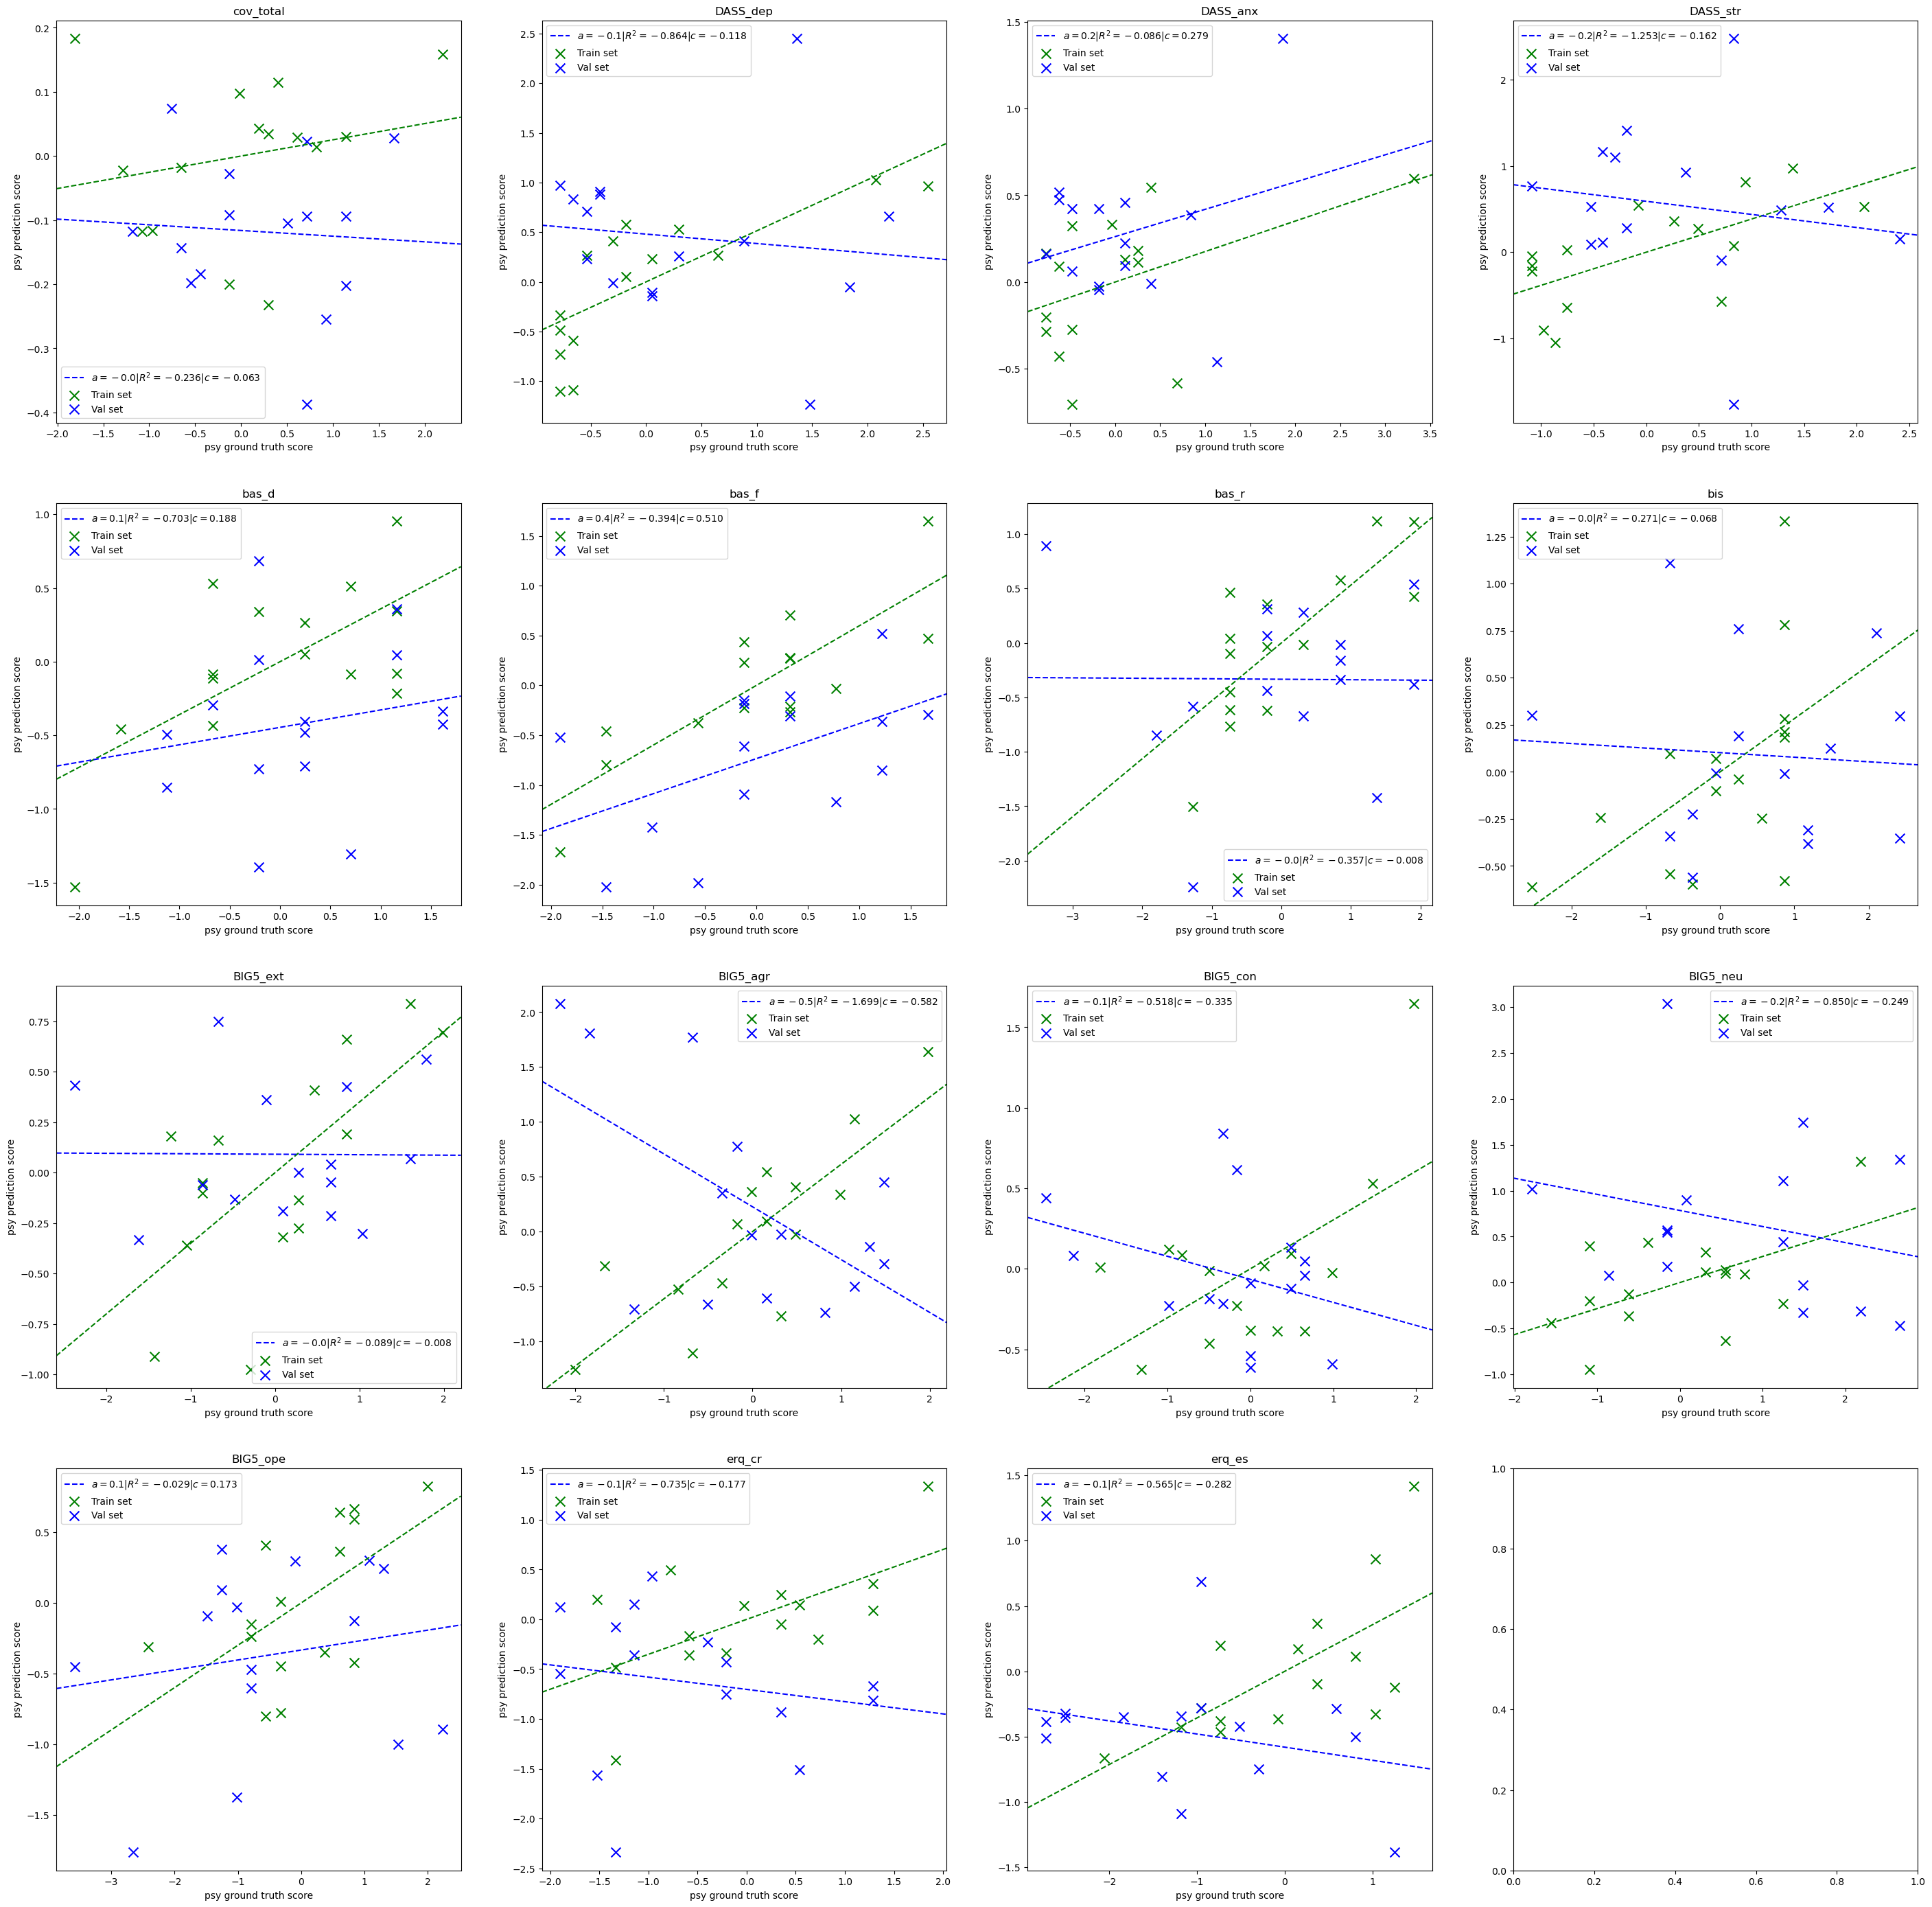

In [12]:
fig, ax   = plt.subplots(4,4, figsize=(35,35))
corr_grad = np.zeros((len(existing_psy)))
n = len(psyscore)
for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    
    # leave one out val prediction score
    j = 15
    clf  = Ridge(alpha=5)
    tmp  = psyscore[:j]
    tmp2 = features[:j]

    y, m, s = zscore(tmp, ret_param=True)
    clf.fit(tmp2, y)

    topredict = features[j:]
    gt   = (psyscore[j:]-m)/s

    pred1 = clf.predict(tmp2)
    pred2 = clf.predict(topredict)
    
    r2   = r2_score(gt,pred2)
    m1, b1 = np.polyfit(y, pred1, deg=1)
    m2, b2 = np.polyfit(gt, pred2, deg=1)
    corr   = stats.pearsonr(gt, pred2).statistic
    
    corr_grad[i] = corr
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, color='g')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={corr:.3f}$', color='b')

    ax[r,c].scatter(y, pred1, s=100, marker='x', color='g', label="Train set")
    ax[r,c].scatter(gt, pred2, s=100, marker='x', color='b', label="Val set")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

Ridge on Features selected + (shuffling the elements)

In [65]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression

A = gradients[:,:,:2].reshape(30,-1)

100%|██████████| 15/15 [02:41<00:00, 10.75s/it]


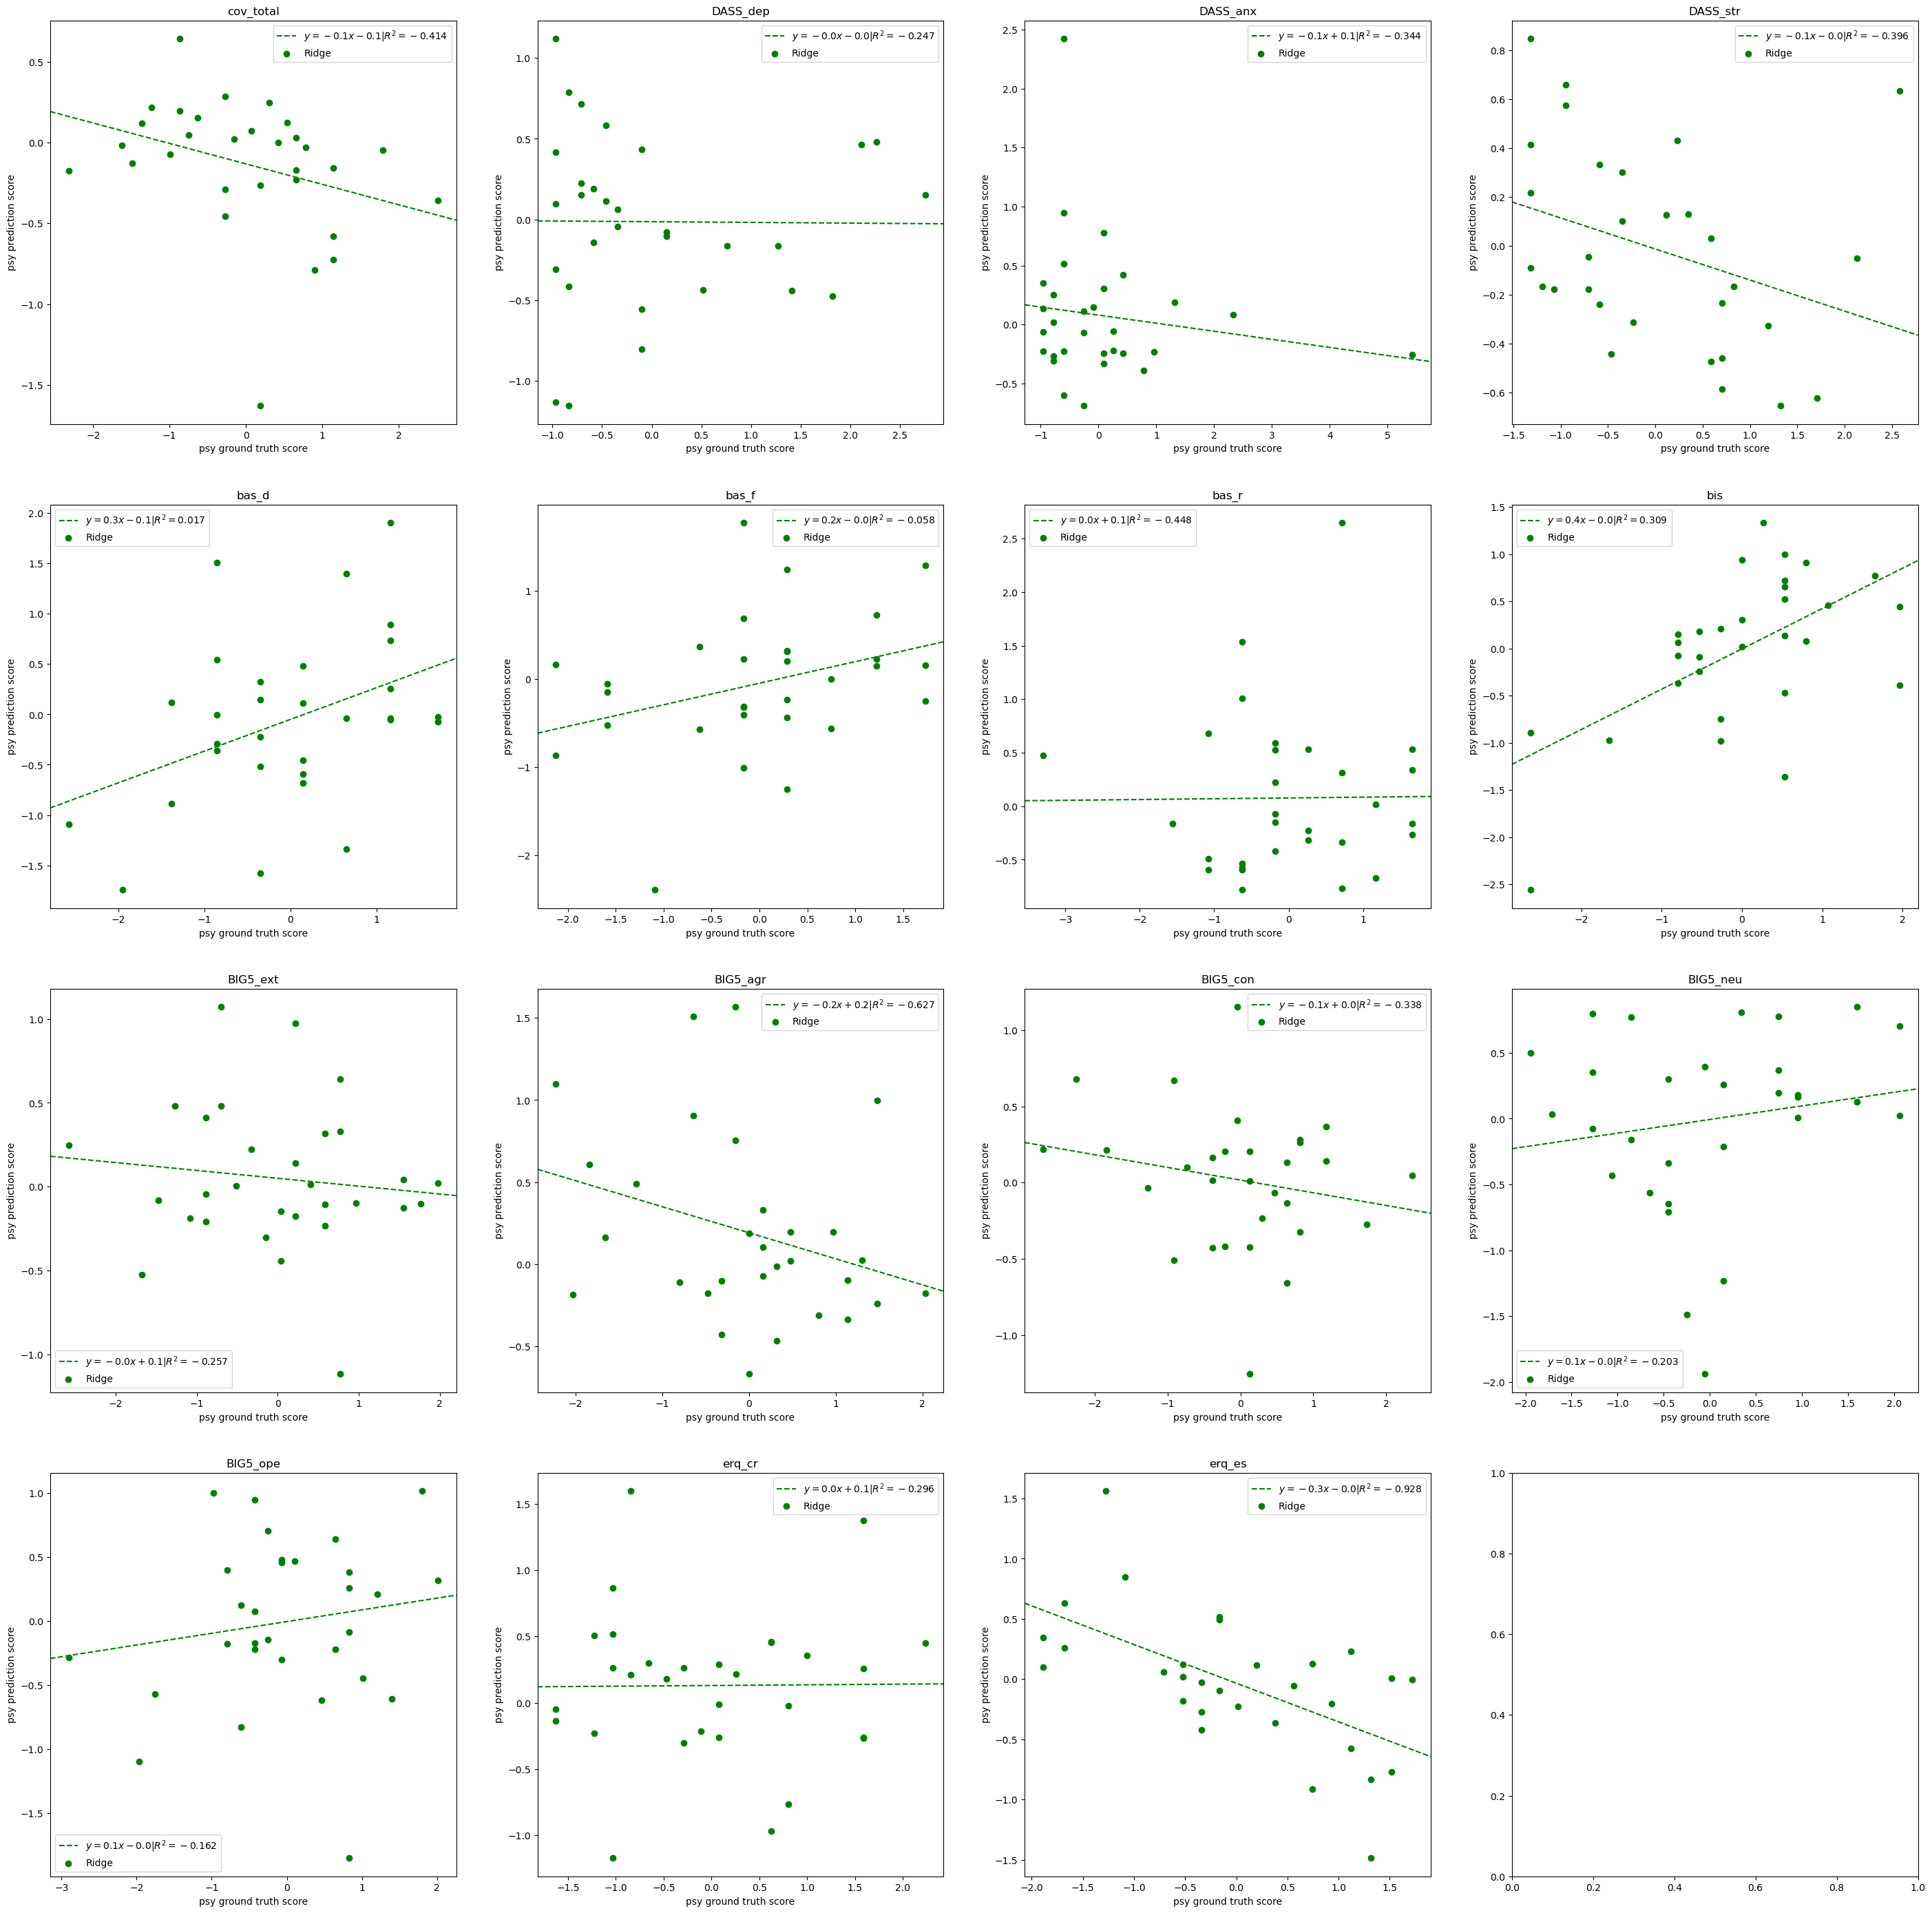

In [68]:
fig, ax = plt.subplots(4,4, figsize=(35,35))


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    clf  = Ridge(alpha=1.0)

    # leave one out val prediction score    
    pts  = []
    pts2 = []
    pts3 = []
    for i in range(len(psyscore)):
        # select number of percentile
        tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
        tmp2 = np.concatenate([A[:i], A[i+1:]])

        selector = SelectPercentile(mutual_info_regression, percentile=.5)
        selector.fit(tmp2, tmp)
        
        newfeatures = A[:,selector.get_support()]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2[:,selector.get_support()], y)

        topredict = newfeatures[i]
        gt = (psyscore[i]-m)/s

        pts2.append([clf.predict([topredict])[0], gt])
        
    pts2 = np.asarray(pts2)

    r2 = r2_score(pts2[:,1],pts2[:,0])
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')

    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")

    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

In [90]:
fig, ax   = plt.subplots(4,4, figsize=(35,35))
corr_grad = np.zeros((len(existing_psy)))
n = len(psyscore)

searchzone = [1,2,3,4,5,7]
psy_k = []
for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)

    best_corr  = -1
    best_corr2 = -1
    best_pred1 = []
    best_pred2 = []
    best_y     = []
    best_gt    = []
    best_s     = 0

    
    for nbk in searchzone:
 
        j = 15
        clf  = Ridge(alpha=1)
        tmp  = psyscore[:j]
        
        selector = SelectKBest(mutual_info_regression, k=nbk)
        selector.fit(A[:j], tmp)

        newfeatures = A[:,selector.get_support()]
        tmp2 = newfeatures[:j]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict1 = newfeatures[j:j+5]
        topredict2 = newfeatures[j+5:]
        gt1   = (psyscore[j:j+5]-m)/s
        gt2   = (psyscore[j+5:]-m)/s

        pred  = clf.predict(tmp2)
        pred1 = clf.predict(topredict1)
        pred2 = clf.predict(topredict2)
        corr   = stats.pearsonr(gt1, pred1).statistic
        corr2  = stats.pearsonr(gt2, pred2).statistic
        if corr > best_corr:
            best_pred = pred
            best_pred1 = pred1
            best_pred2 = pred2
            best_y      = y
            best_gt1    = gt1
            best_gt2    = gt2
            best_corr  = corr
            best_corr2 = corr2
            best_s     = nbk

    r2   = r2_score(best_gt1,best_pred1)
    r3   = r2_score(best_gt2,best_pred2)
    m1, b1 = np.polyfit(best_y, best_pred, deg=1)
    m2, b2 = np.polyfit(best_gt1, best_pred1, deg=1)
    m3, b3 = np.polyfit(best_gt2, best_pred2, deg=1)
    
    corr_grad[i] = best_corr
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, color='g')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={best_corr:.3f}$', color='b')
    ax[r,c].axline(xy1=(0, b3), linestyle='--', slope=m3, label=f'$a = {m3:.1f} | R^2={r3:.3f} | c={best_corr2:.3f}$', color='r')

    ax[r,c].scatter(best_y, best_pred, s=100, marker='x', color='g', label="Train set")
    ax[r,c].scatter(best_gt1, best_pred1, s=100, marker='x', color='b', label="Val set | s={}".format(best_s))
    ax[r,c].scatter(best_gt2, best_pred2, s=100, marker='x', color='r', label="Test set")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()
    psy_k.append(best_s)

In [37]:
# For best model for ridge / number of features found above 
# We try to shuffle the dataset and refit to see prediction strength

j = 20 # We fix the split to be 20 and split it the same way all the time

C = np.zeros((len(existing_psy), 100))
for i in tqdm(range(len(existing_psy))):
    indices = np.arange(0,30)
    for n in range(20):
        np.random.shuffle(indices)

        k    = psy_k[i]
        feat = existing_psy[i]

        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
        psyscore = np.array(psyscore)

        selector = SelectKBest(mutual_info_regression, k=k)
        selector.fit(A[indices[:j]], psyscore[indices[:j]])
        newfeatures = A[:,selector.get_support()]

        clf  = Ridge(alpha=1)
        tmp  = psyscore[indices[:j]]
        tmp2 = newfeatures[indices[:j]]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = newfeatures[indices[j:]]
        gt   = (psyscore[indices[j:]]-m)/s

        pred2  = clf.predict(topredict)
        corr   = stats.pearsonr(gt, pred2).statistic
        C[i,n] = corr

100%|██████████| 15/15 [02:33<00:00, 10.25s/it]


#### Test distribution

In [44]:
np.random.seed(99)
distribsA = []
n = len(psyscore)
j = 20
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    selector = SelectKBest(mutual_info_regression, k=psy_k[i])
    selector.fit(A[:j], psyscore[:j])
    newfeatures = A[:,selector.get_support()]    
    
    null_distrib = []
    for _ in range(1000):
        np.random.shuffle(psyscore)

        clf  = Ridge(alpha=1)
        tmp  = psyscore[:j]
        tmp2 = newfeatures[:j]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = newfeatures[j:]

        gt = (psyscore[j:]-m)/s
    
        pred = clf.predict(topredict)
        corr   = stats.pearsonr(pred, gt).statistic
        null_distrib.append(corr)
    distribsA.append(null_distrib)

100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


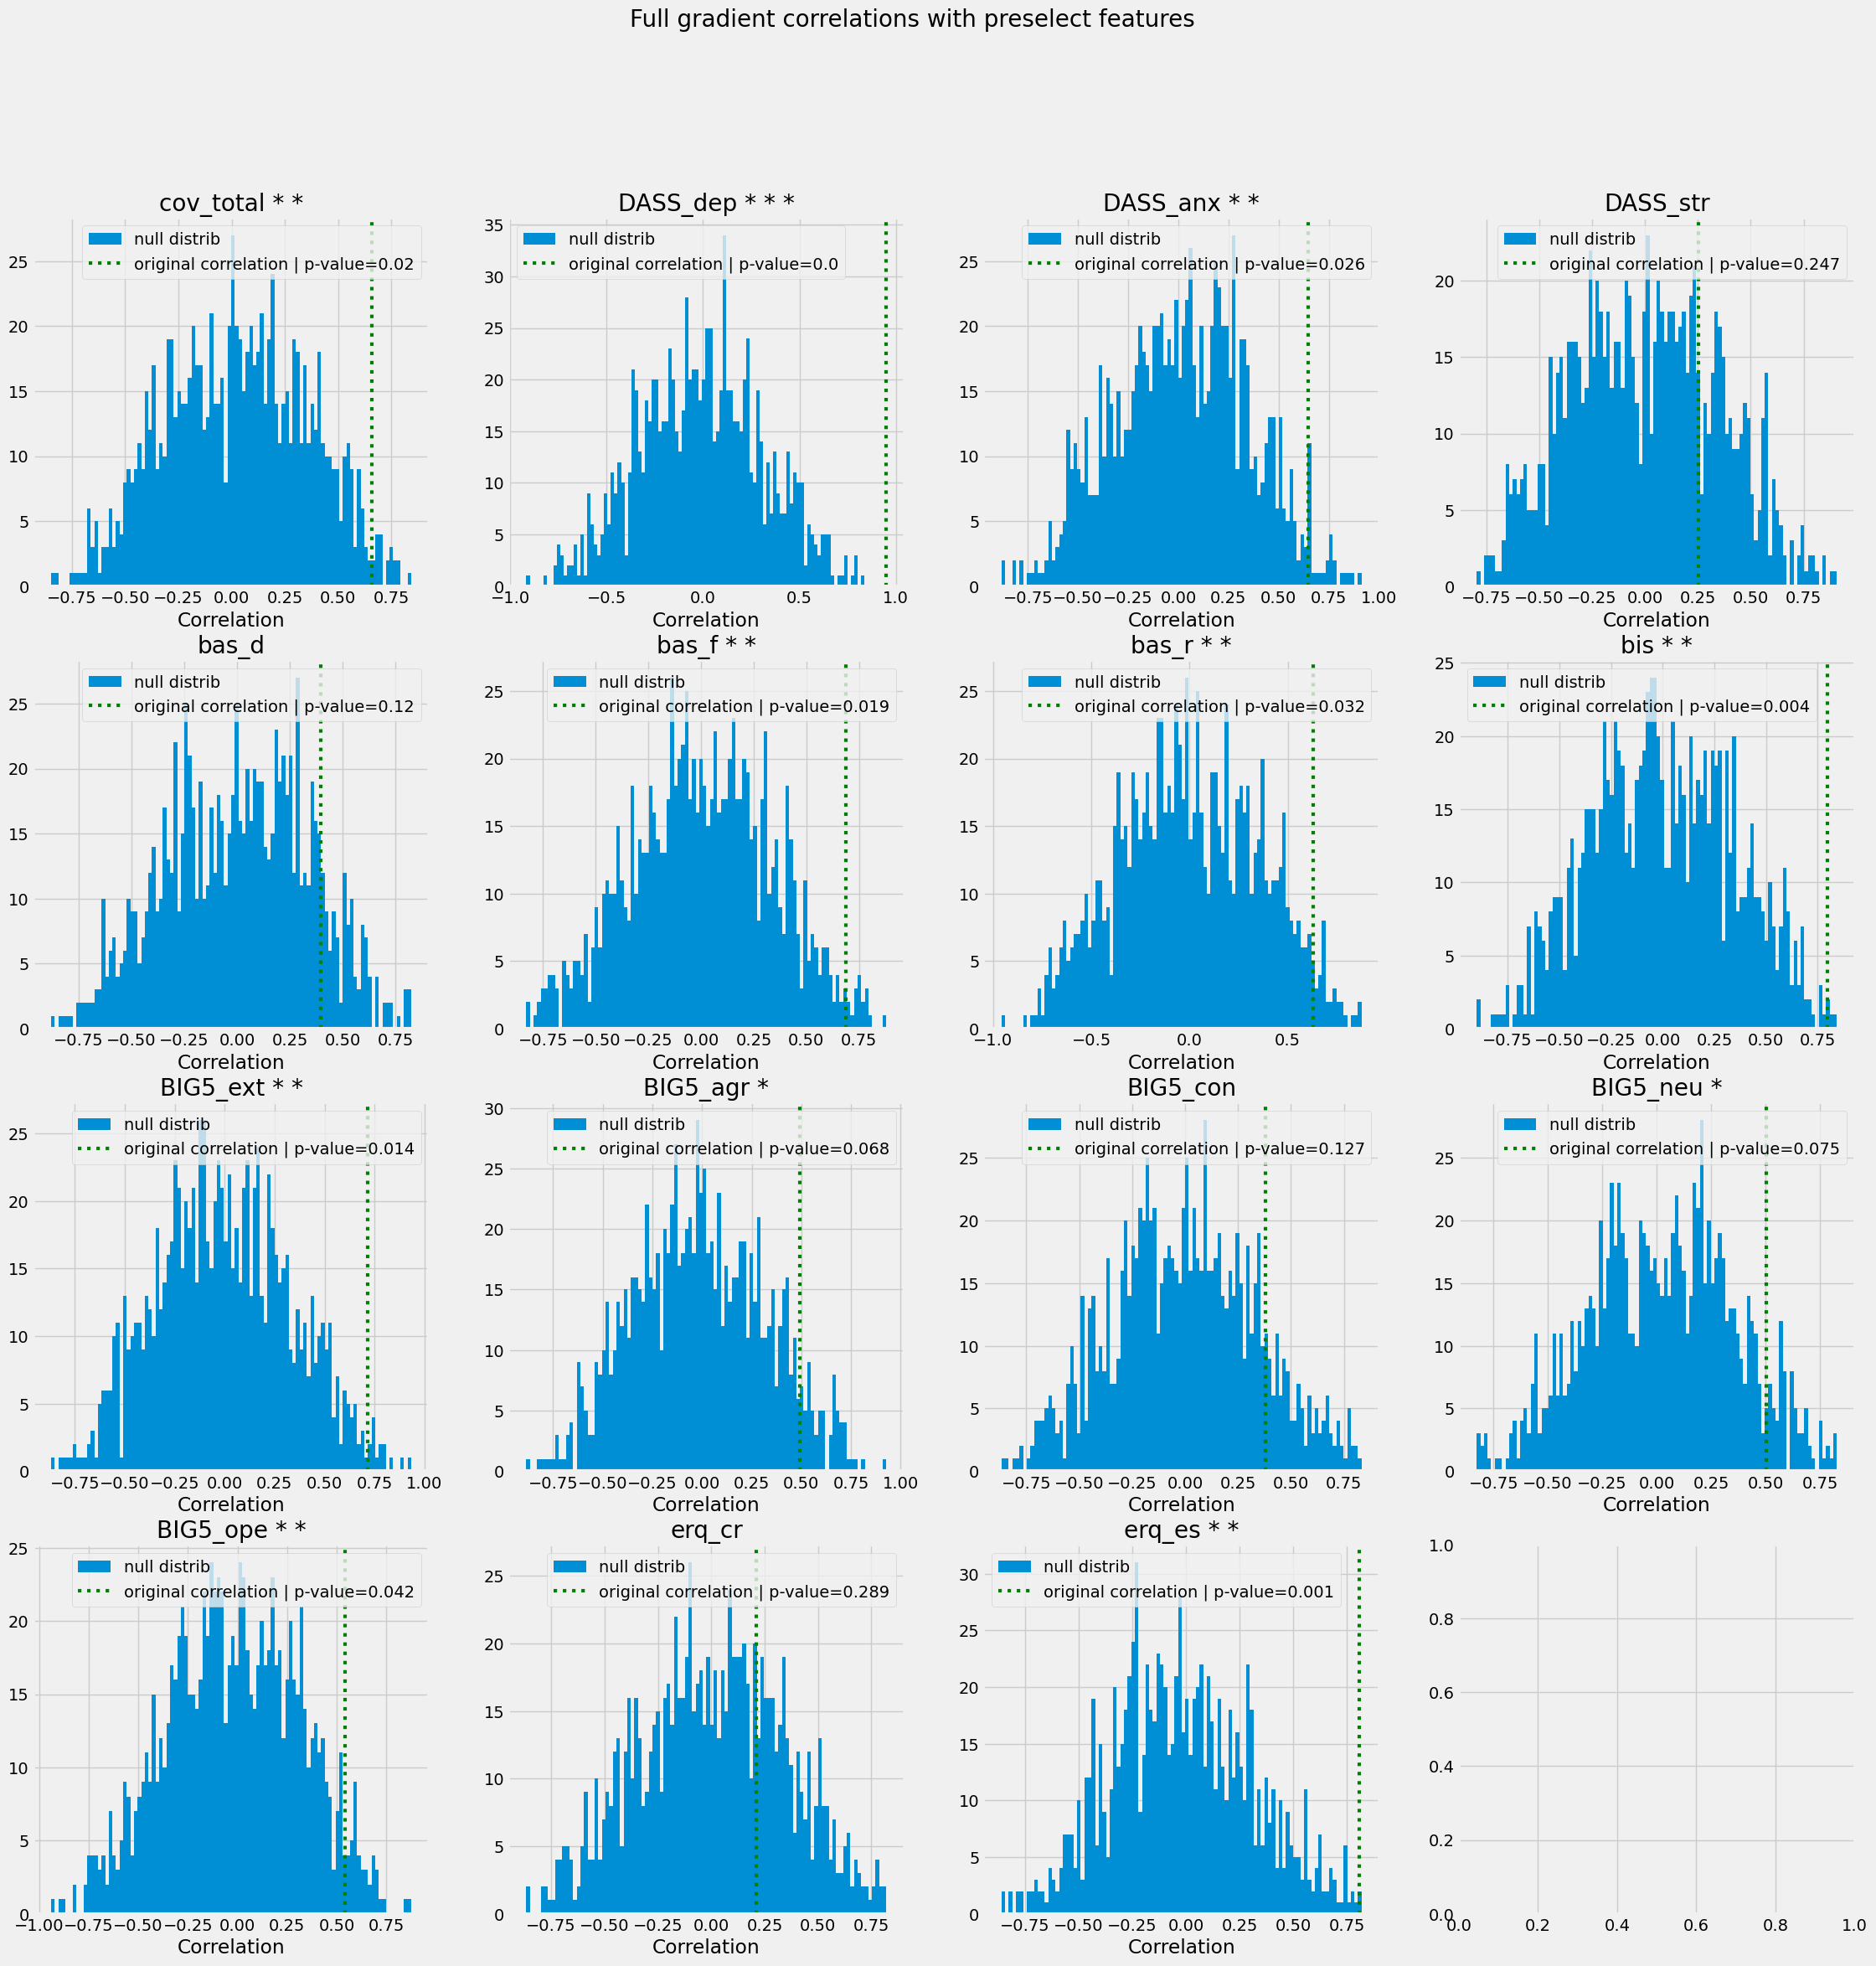

In [46]:
fig, ax = plt.subplots(4,4, figsize=(25,25))

for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    pval = null_score(distribsA[i], corr_grad[i])
    ax[r,c].hist(distribsA[i],bins=100, label='null distrib')

    if corr_grad[i] >= 0:
        ax[r,c].axvline(x=corr_grad[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format(pval))
        nbstar = int(pval < 0.05) + int(pval < 0.1) + int(pval < 0.001)
        ax[r,c].set_title(feat + ' *'*nbstar)
    else:
        ax[r,c].axvline(x=corr_grad[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format("negcorr"))
        ax[r,c].set_title(feat)

    ax[r,c].set_xlabel('Correlation')
    ax[r,c].legend()

plt.suptitle('Full gradient correlations with preselect features', size=20)
plt.show()

## On Dynamic Gradients

In [72]:
# Loading gradients 
subject_grad = load('./resources/dynamic_grad/individual_level/Rest_40_grad.pkl')
subjects     = list(subject_grad.keys())

In [82]:
subject_grad['S17'][0].shape

(343, 400, 10)

In [ ]:
# # 4. Distribution vectors
# D1,D2,c3 = [], [], []
# nbin = 15
# d2gradients = np.zeros((len(order), nbin, 2))
# for i in order:
#     d2gradients[i,:,0] = np.histogram(gradients[i][:,0], bins=nbin)[0]
#     d2gradients[i,:,1] = np.histogram(gradients[i][:,1], bins=nbin)[0]

#     D1 += list(np.histogram(gradients[i][:,0], density=True, bins=nbin)[0])
#     D2 += list(np.histogram(gradients[i][:,0], density=True, bins=nbin)[0])
#     c3 += [psyscore[i]] * nbin

# dgradients = d2gradients[:,:,1]

In [ ]:
# #SVM and Ridge on Distributions

# fig, ax = plt.subplots(4,4, figsize=(35,35))


# for i in range(len(existing_psy)):
#     feat = existing_psy[i]
#     r,c = i //4, i % 4

#     psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
#     psyscore = np.array(psyscore)
#     regr = SVR(C=1.0, epsilon=0.2)
#     clf  = Ridge(alpha=1.0)

#     # leave one out val prediction score    
#     pts  = []
#     pts2 = []
#     pts3 = []
#     for i in range(len(psyscore)):
#         tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
#         tmp2 = np.concatenate([dgradients[:i].max(axis=1), dgradients[i+1:].max(axis=1)])

#         y, m, s = zscore(tmp, ret_param=True)
#         regr.fit(tmp2[:,None], y)
#         clf.fit(tmp2[:,None], y)

#         topredict = dgradients[i].max()
#         gt = (psyscore[i]-m)/s

#         pts.append([regr.predict([[topredict]])[0], gt])
#         pts2.append([clf.predict([[topredict]])[0], gt])
        
#     pts  = np.asarray(pts)
#     pts2 = np.asarray(pts2)

#     r1 = r2_score(pts[:,1],pts[:,0])
#     r2 = r2_score(pts2[:,1],pts2[:,0])

#     m1, b1 = np.polyfit(pts[:,1], pts[:,0], deg=1)
#     m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    
#     ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, label=f'$y = {m1:.1f}x {b1:+.1f} | R^2={r1:.3f}$', color='r')
#     ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')

#     ax[r,c].scatter(pts[:,1], pts[:,0], color='r',label='SVM')
#     ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")

#     ax[r,c].set_title("{}".format(feat))
#     ax[r,c].set_xlabel("psy ground truth score")
#     ax[r,c].set_ylabel("psy prediction score")
#     ax[r,c].legend()
#     # ax[r,c].set_ylim(-5,5)

In [ ]:
#### Data Splitting: training / validation
# We split accordingly to have the same number of above-mean and below-mean points

# # feature of interest
# grad_idx = 0
# feat     = "erq_es"
# cutoff   = behavioural[['ID', feat]].mean().iloc[0]
# nb_above = np.sum(np.array(list(behavioural[feat])) > cutoff)
# nb_below = np.sum(np.array(list(behavioural[feat])) <= cutoff)

# np.random.seed(0)
# a = np.random.choice(np.where(behavioural[feat] > cutoff)[0], int(nb_above/2), replace=False)
# b = np.random.choice(np.where(behavioural[feat] <= cutoff)[0], int(nb_below/2), replace=False)

# trainIds = list(behavioural.ID.iloc[a]) + list(behavioural.ID.iloc[b])
# valIds   = [b for b in list(behavioural.ID) if b not in trainIds]

# # We use first gradient as a point
# X_train = np.asarray([subject_grad[t][:,grad_idx] for t in trainIds])
# y_train = np.asarray([behavioural[behavioural.ID == t][feat].iloc[0] for t in trainIds])

# X_val = np.asarray([subject_grad[t][:,grad_idx] for t in valIds])
# y_val = np.asarray([behavioural[behavioural.ID == t][feat].iloc[0] for t in valIds])

# # forcing the style since sns changes it when we call default set size
# plt.style.use('fivethirtyeight')
# plt.figure(figsize=(15,5))
# sw = 40
# plt.plot(overlap_add(X_train[8], sw), label=y_train[8])
# plt.plot(overlap_add(X_train[9], sw), label=y_train[9])
# plt.plot(overlap_add(X_train[1], sw), label=y_train[1])
# plt.plot(overlap_add(X_train[6], sw), label=y_train[6])
# plt.plot(overlap_add(X_train[4], sw), label=y_train[4])
# plt.title("Gradient 1 (400 parcels) of different subjects with behavioural value")
# plt.legend()